In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

df=pd.read_csv("df_abo_step1.csv",parse_dates =True) 

df.head(2) #dec 2008 à Juin 2017 #Rainfall, Evaporationphoto à 9am et 3pm (vent (vitesse et direction), nuage, humidité,temperature et pression)
#Conversion de la date au format Datetime
display(df.head(2)) #dec 2008 à Juin 2017 #photo à 9am et 3pm (vent (vitesse et direction), nuage, humidité,temperature et pression)
df.shape
display(df.info())

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Lat,Lon,month_sin,month_cos,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos
0,2008-12-01,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,...,-36.073773,146.913526,-0.5,0.866025,-1.00000,-1.836970e-16,-1.000000,-1.836970e-16,-0.92388,0.382683
1,2008-12-02,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,...,-36.073773,146.913526,-0.5,0.866025,-0.92388,3.826834e-01,-0.382683,9.238795e-01,-0.92388,-0.382683


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124218 entries, 0 to 124217
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date             124218 non-null  object 
 1   Location         124218 non-null  object 
 2   MinTemp          123991 non-null  float64
 3   MaxTemp          124197 non-null  float64
 4   Rainfall         123330 non-null  float64
 5   WindGustSpeed    119410 non-null  float64
 6   WindSpeed9am     123786 non-null  float64
 7   WindSpeed3pm     123807 non-null  float64
 8   Humidity9am      123130 non-null  float64
 9   Humidity3pm      122480 non-null  float64
 10  Pressure9am      122684 non-null  float64
 11  Pressure3pm      122684 non-null  float64
 12  Cloud9am         80968 non-null   float64
 13  Cloud3pm         78975 non-null   float64
 14  Temp9am          123909 non-null  float64
 15  Temp3pm          124197 non-null  float64
 16  RainTomorrow     124218 non-null  int6

None

In [2]:
print("Nb NaN",df.isna().sum().sum())
print("soit",round(df.isna().sum().sum()/(df.shape[0]*df.shape[1]),4)*100,"% du dataset")
display(pd.DataFrame(df.isna().sum(), columns=["Nombre de NA"]))

Nb NaN 127922
soit 3.6799999999999997 % du dataset


,Nombre de NA
Date,0
Location,0
MinTemp,227
MaxTemp,21
Rainfall,888
WindGustSpeed,4808
WindSpeed9am,432
WindSpeed3pm,411
Humidity9am,1088
Humidity3pm,1738


In [3]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# On retire les colonnes qu'on ne souhaite pas imputer
df_impute = df.drop(columns=['Date', "Location", "RainTomorrow"]).copy()
# On garde certaines colonnes pour les réintégrer après (pour l'analyse ou la modélisation)
df_ajout = df[['Date', "Location", "RainTomorrow",'month_sin', 'month_cos', 'Lat', 'Lon']].copy()

# 3. Renforcer l'impact de certaines variable avec * Facteur ajustable
df_impute['month_sin'] = df_impute['month_sin'] * 20  # Facteur de pondération (ajustable)
df_impute['month_cos'] = df_impute['month_cos'] * 20  # Facteur de pondération (ajustable)
df_impute['Lat'] = df_impute['Lat'] * 10  # Facteur ajustable
df_impute['Lon'] = df_impute['Lon'] * 10  # Facteur ajustable

# 6. Standardiser les données pour améliorer le calcul des distances
scaler = StandardScaler()
df_impute_scaled = pd.DataFrame(scaler.fit_transform(df_impute), columns=df_impute.columns)

# 7. Imputation par KNN (en donnant plus de poids aux voisins proches via 'distance')
imputer = KNNImputer(n_neighbors=3, weights='distance')
df_imputed_values = imputer.fit_transform(df_impute_scaled)

# 8. Annuler la standardisation pour revenir aux échelles d'origine
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_values), columns=df_impute.columns)

# 9. Supprimer les colonnes pondérées
df_imputed = df_imputed.drop(['month_sin', 'month_cos', 'Lat', 'Lon'],axis=1)

# 10. Réintégrer les colonnes retirées pour l'imputation
df_imputed = df_imputed.merge(right=df_ajout, left_index=True, right_index=True)

# 11. Vérifier qu'il ne reste plus de valeurs manquantes et afficher un aperçu
print("Nombre total de NaN restants :", df_imputed.isna().sum().sum())
display(df_imputed.head(2))

Nombre total de NaN restants : 0


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,Date,Location,RainTomorrow,month_sin,month_cos,Lat,Lon
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,-1.836638e-16,-0.92388,0.382683,2008-12-01,Albury,0,-0.5,0.866025,-36.073773,146.913526
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,9.238795e-01,-0.92388,-0.382683,2008-12-02,Albury,0,-0.5,0.866025,-36.073773,146.913526


Cloud NaN : crée une feature cloud absent

Puis compléter les NaN de cloud?

In [4]:
df=df_imputed.drop(["Location","Date"],axis=1)

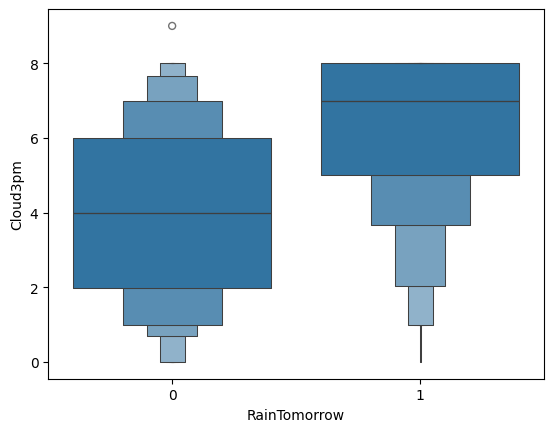

In [5]:
sns.boxenplot(data=df, x="RainTomorrow", y="Cloud3pm")
plt.show()

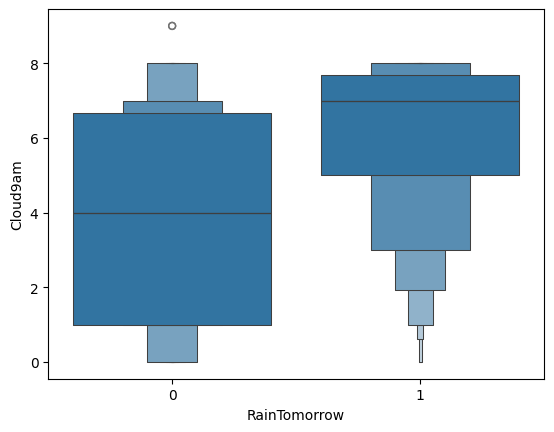

In [6]:
sns.boxenplot(data=df, x="RainTomorrow", y="Cloud9am")
plt.show()

<Axes: >

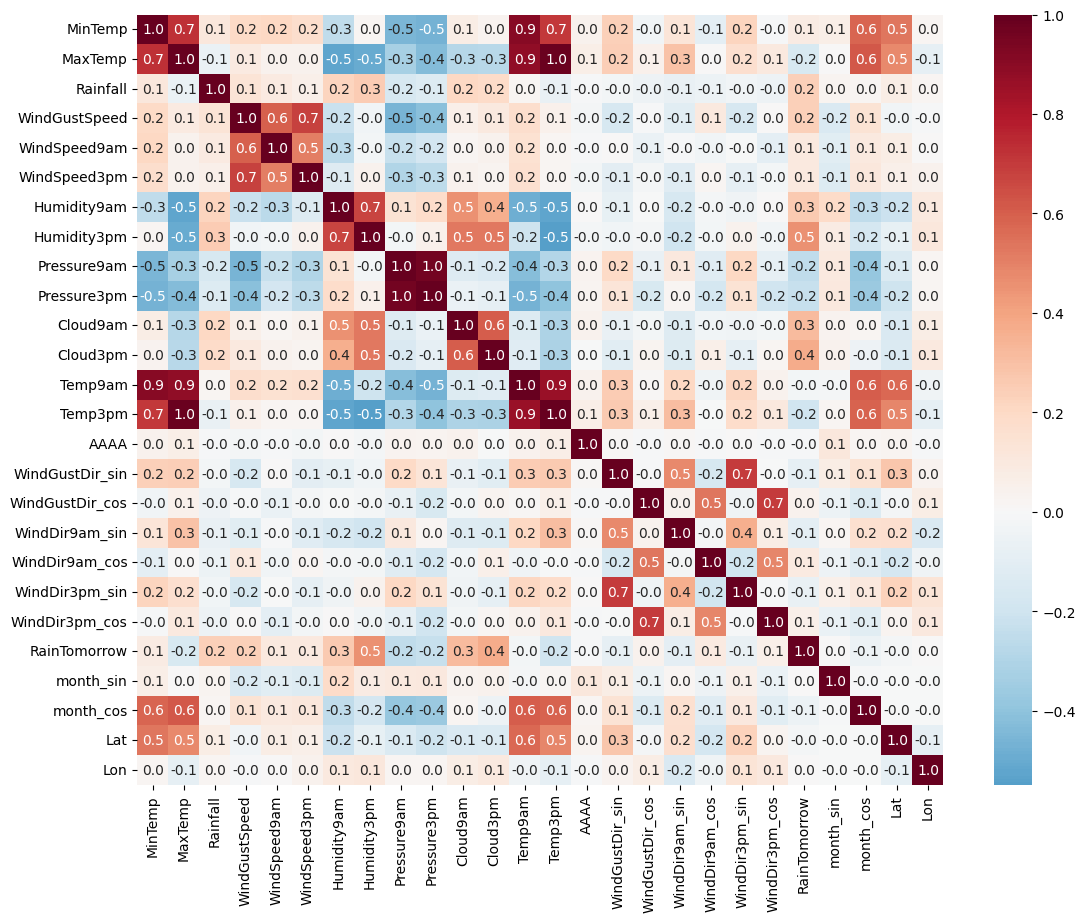

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

#DataFrame sans date, Location, Wind, RainToday, RainTomorrow
dataframe_correlation=df
dataframe_correlation=dataframe_correlation.select_dtypes(include = ['int', 'float'])

#Corrélation de Pearson entre les variables explicatives quantitatives présentées sous forme de Heatmap
plt.figure(figsize=(13, 10))  # Optional: Adjust figure size
sns.heatmap(dataframe_correlation.corr(),annot=True,cmap="RdBu_r",fmt= ".1f", center = 0) 

## TEST STAT

##### Je souhaite faire une analyse exploratoire par PCA et UMAP
##### Je vais donc scaler les variables quantitatives en choisissant les méthodes selon leur distribution sur tout le dataset sans NA
#### Puis je ferai un encodage des variables catégorielles (là aussi sur tout le df sans NaN) -> utile pour PCA et UMAP??

#### SCALING VAR QUANTI : Analyse sur tout le df sans NaN

In [8]:
vars_continues = df.select_dtypes(include="number").columns
df_var_continue = df[vars_continues]

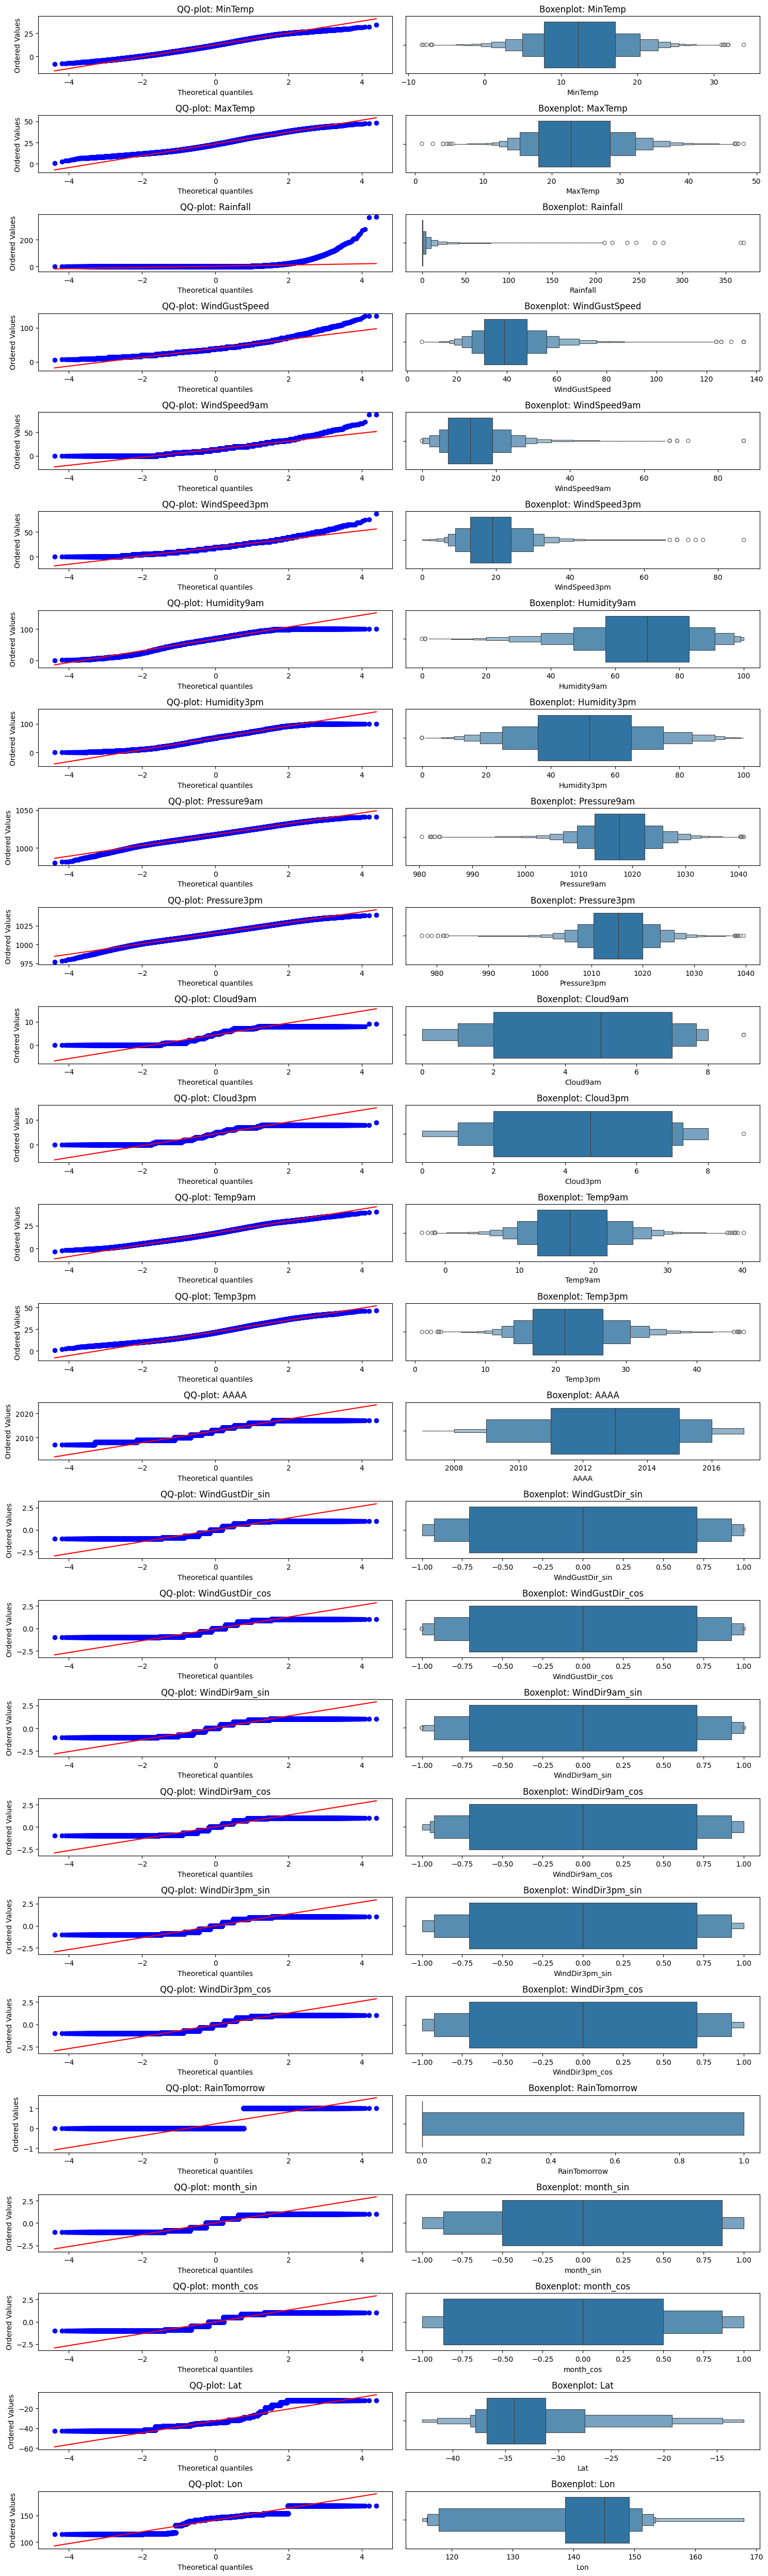

In [9]:
import scipy.stats as stats


# Création de la figure avec 2 colonnes et autant de lignes que de colonnes dans df
fig, axes = plt.subplots(nrows=len(df_var_continue.columns), ncols=2, figsize=(15, 50))

# Parcours de chaque colonne
for i, col in enumerate(df_var_continue.columns):
    # Sélectionner l'axe pour le QQ-plot
    plt.sca(axes[i, 0])    
    # QQ-plot (à gauche)
    stats.probplot(df_var_continue[col].dropna(), dist="norm", plot=plt)
    axes[i, 0].set_title(f'QQ-plot: {col}')

    # Boxenplot (à droite)
    sns.boxenplot(x=df_var_continue[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxenplot: {col}')

plt.tight_layout()
plt.show()


MinMaxScaling : Distribution PAS normale + très peu outliers : (mais utile pour des descentes de gradient (=reseau de neurone) car a besoin d'intervalle [0;1])
> Dans un intervalle de 0 à 100% 'Humidity9am', 'Humidity3pm'

StandardScaling : Distribution "presque" normale + quelques valeurs extrêmes pour Temp(Min/Max/9am/3pm) et Pressure(9am/3pm)

RobustScaling : Quand il y a beaucoup d'outliers : 
WindSpeed(9am/3pm/Gust) n'a pas une distribution normale et a des valeurs extrêmes
Même chose pour Rainfall (qui pourrait avoir besoin d'un traitement supplémentaire au vue de sa distribution)

**## Peut-on avoir des colonnes avec des scaling différents? certaines méthodes etant plus adapté à certains modeles :-/?
## Si on fait un scaling log sur rainfall, quel est l'impact ensuite?**

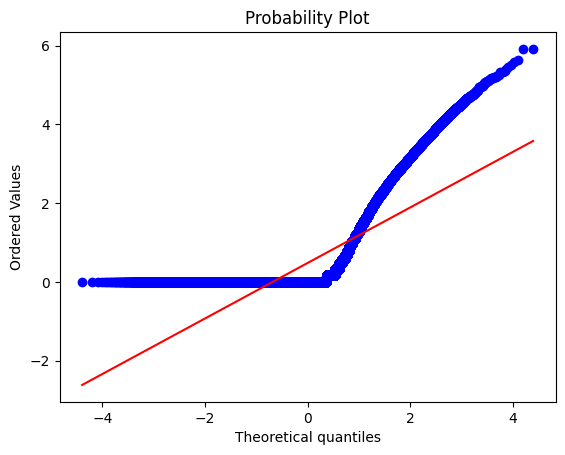

In [10]:
#Test de transformation avant robust scaler

#log
log_rain = (np.log(df['Rainfall'] + 1))

stats.probplot(log_rain, dist="norm", plot=plt);

#### NB : si on utilise Rainfall pour une régression : penser à faire exp(rain_log_predite)-1 avant d'appliquer le seuil
### Mais est-ce pertinent d'encoder une variable cible? (si régression)

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scaling(df,scaler_importe,liste_features):
    df_to_scale = df[liste_features]
    scaler = scaler_importe()
    scaler.fit(df_to_scale)
    df_scaled = pd.DataFrame(data=scaler.transform(df_to_scale), index = df_to_scale.index, columns=df_to_scale.columns)
    return df_scaled

df['Rainfall'] = (np.log(df['Rainfall'] + 1))

scaling_std = ["MinTemp", "MaxTemp","Temp9am", "Temp3pm","Pressure9am","Pressure3pm"]
scaling_min_max = ["Humidity9am", "Humidity3pm","Lat","Lon","AAAA","Cloud9am","Cloud3pm"]
# Comment encoder Cloud?
scaling_robust = ["WindGustSpeed", "WindSpeed9am","WindSpeed3pm","Rainfall"]


df_scaled_std = scaling(df, StandardScaler, scaling_std)
df_scaled_min = scaling(df, MinMaxScaler, scaling_min_max)
df_scaled_robust = scaling(df, RobustScaler, scaling_robust)


MM : pas sure prendretrigo
cloud ??

In [12]:
df = df.drop(scaling_std, axis = 1)
df = df.merge(right=df_scaled_std, left_index=True, right_index=True)

df = df.drop(scaling_min_max, axis = 1)
df = df.merge(right=df_scaled_min, left_index=True, right_index=True)

df = df.drop(scaling_robust, axis = 1)
df = df.merge(right=df_scaled_robust, left_index=True, right_index=True)

display(df.columns)
display(df.head(2))

Index(['WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'RainTomorrow',
       'month_sin', 'month_cos', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm',
       'Pressure9am', 'Pressure3pm', 'Humidity9am', 'Humidity3pm', 'Lat',
       'Lon', 'AAAA', 'Cloud9am', 'Cloud3pm', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Rainfall'],
      dtype='object')

,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,RainTomorrow,month_sin,month_cos,MinTemp,...,Humidity3pm,Lat,Lon,AAAA,Cloud9am,Cloud3pm,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Rainfall
0,-1.00000,-1.734723e-16,-1.000000,-1.836638e-16,-0.92388,0.382683,0,-0.5,0.866025,0.154898,...,0.22,0.223809,0.601974,0.1,0.888889,0.442961,0.294118,0.583333,0.454545,0.885749
1,-0.92388,3.826834e-01,-0.382683,9.238795e-01,-0.92388,-0.382683,0,-0.5,0.866025,-0.781223,...,0.25,0.223809,0.601974,0.1,0.178571,0.562661,0.294118,-0.750000,0.272727,0.000000


Variable categorielle

## EDA Avancé : Pour voir des structures sous-jacentes
PCA, Umap et clustering
-> nécessite des datas scalées
### quid des variables catégorielles nominale, ordinale et Date? faut-il les encoder?


In [13]:
vars_continues =df.select_dtypes(exclude=["datetime",object]).columns
df_var_continue = df[vars_continues]

df_var_continue = df_var_continue.drop(["RainTomorrow"], axis=1)
display(df_var_continue.describe())

,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,month_sin,month_cos,MinTemp,MaxTemp,...,Humidity3pm,Lat,Lon,AAAA,Cloud9am,Cloud3pm,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Rainfall
count,124218.000000,1.242180e+05,1.242180e+05,1.242180e+05,124218.000000,1.242180e+05,1.242180e+05,1.242180e+05,1.242180e+05,1.242180e+05,...,124218.000000,124218.000000,124218.000000,124218.000000,124218.000000,124218.000000,124218.000000,124218.000000,124218.000000,1.242180e+05
mean,-0.012170,-4.967557e-02,4.549538e-02,4.158539e-03,-0.015452,-4.478874e-02,2.060889e-02,-9.978049e-03,2.837183e-17,5.857410e-16,...,0.512127,0.336600,0.502679,0.576115,0.490773,0.491681,0.051439,0.092813,-0.009572,9.099748e-01
std,0.711289,6.928140e-01,6.826886e-01,7.061613e-01,0.711115,6.984378e-01,7.071779e-01,7.066705e-01,1.000004e+00,1.000004e+00,...,0.207301,0.211473,0.227485,0.253121,0.295313,0.276951,0.782506,0.725746,0.784232,1.698747e+00
min,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.215137e+00,-3.203390e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.941176,-1.083333,-1.727273,-1.673824e-15
25%,-0.707107,-7.071068e-01,-7.071068e-01,-7.071068e-01,-0.707107,-7.071068e-01,-5.000000e-01,-8.660254e-01,-7.188147e-01,-7.783338e-01,...,0.360000,0.201284,0.444663,0.400000,0.222222,0.222222,-0.470588,-0.500000,-0.545455,0.000000e+00
50%,0.000000,-1.734723e-16,1.249001e-16,6.120321e-17,0.000000,-1.804112e-16,1.224647e-16,-1.836970e-16,-3.232623e-02,-9.361193e-02,...,0.520000,0.285557,0.567352,0.600000,0.554941,0.523591,0.000000,0.000000,0.000000,0.000000e+00
75%,0.707107,7.071068e-01,7.071068e-01,7.071068e-01,0.707107,7.071068e-01,8.660254e-01,5.000000e-01,7.321723e-01,7.194952e-01,...,0.650000,0.384017,0.643371,0.800000,0.777778,0.777778,0.529412,0.500000,0.454545,1.000000e+00
max,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,3.353310e+00,3.515443e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.647059,6.166667,6.181818,1.115450e+01


In [14]:
df_var_continue.columns

Index(['WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'month_sin',
       'month_cos', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Pressure9am',
       'Pressure3pm', 'Humidity9am', 'Humidity3pm', 'Lat', 'Lon', 'AAAA',
       'Cloud9am', 'Cloud3pm', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Rainfall'],
      dtype='object')

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(df_var_continue)
data_pca = pca.transform(df_var_continue)  # renvoie array de 2 colonnes #Coord


print(pca.explained_variance_) # Variance absolue par axes factorielle. Pour connaître l'échelle exacte de la variance (ajouter .sum()): top pour analyse comparative ou vérif stat

print(pca.explained_variance_ratio_) # Variance relative de chaque composante dans la variance totale (part de variance par axe) (= Variance absolue normalisée entre [0;1])


[4.54782874 3.35217169 1.71098328 1.13440337 0.86694526 0.63652416
 0.49220961 0.40240261 0.2869527  0.28116848]
[0.30344497 0.2236671  0.11416201 0.07569085 0.05784523 0.04247083
 0.03284172 0.02684953 0.01914636 0.01876042]


In [16]:
print("Seule 51% de la variance est expliquée par 2 Composantes Principales, 62% avec 3 PC. Il faut tester des Manifolds")

Seule 51% de la variance est expliquée par 2 Composantes Principales, 62% avec 3 PC. Il faut tester des Manifolds


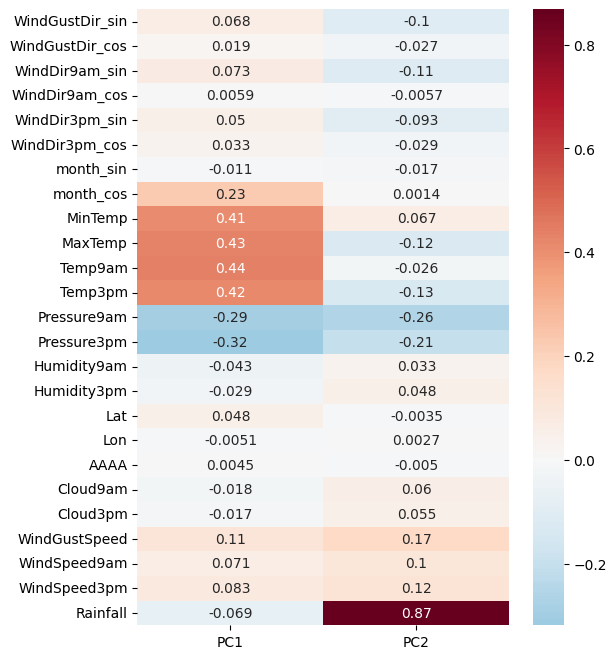

In [17]:
df_charges_factorielles =pd.DataFrame(data = pca.components_[[0,1],:], index = ["PC1","PC2"] ,columns = df_var_continue.columns)
#pca.components_ : Array :  lignes = composantes principales, colonnes = features => charge factorielle. ici on ramène les 2 premières composantes

plt.figure(figsize =(6,8))
sns.heatmap(df_charges_factorielles.T, center = 0, cmap="RdBu_r", annot =True);
#.T pour mettre les axes créés en abscisse


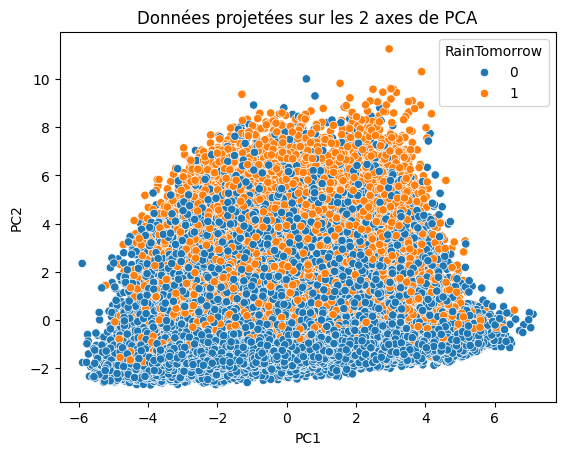

In [18]:
PCA_mat = pd.DataFrame(data = data_pca[:,[0,1]], columns =["PC1", "PC2"]) 
PCA_mat_avec_target = pd.merge(left = PCA_mat, right = df["RainTomorrow"], how= "inner", left_index = True, right_index = True) 

sns.scatterplot(data = PCA_mat_avec_target , x="PC1", y = "PC2", hue = "RainTomorrow");
plt.title("Données projetées sur les 2 axes de PCA");


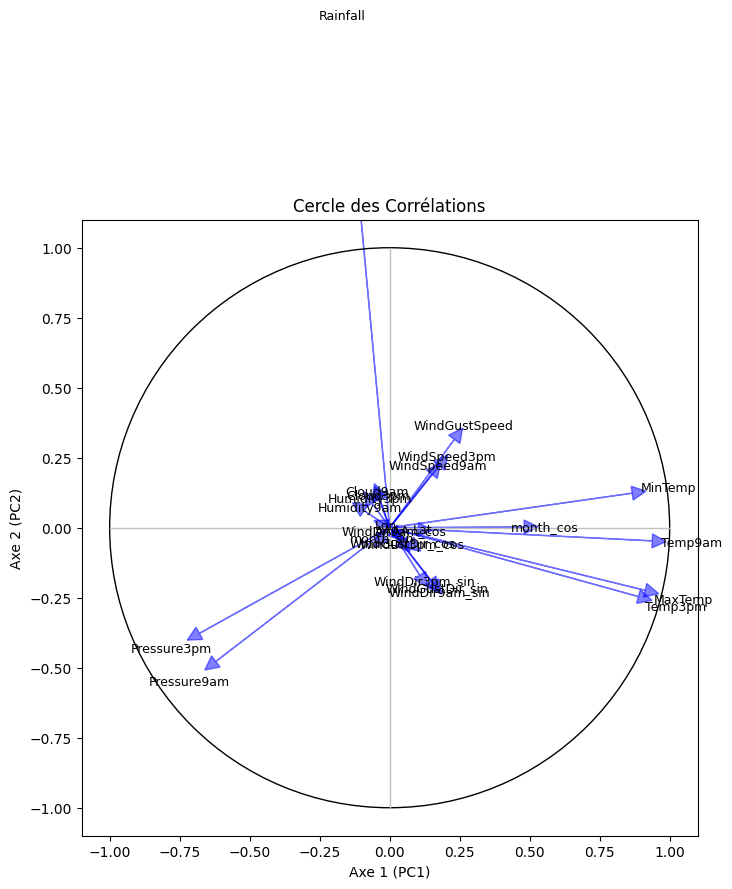

In [19]:
def draw_correlation_circle(df_charges_factorielles, pca, arrow_length=0.05, label_rotation=0):
    """
    Trace le cercle de corrélations (PC1 vs PC2).
    df_charges_factorielles : DataFrame dont l'index = ["PC1", "PC2"]
                              et les colonnes = noms des variables.
    pca : l'objet PCA déjà ajusté (fit).
    arrow_length : la taille de la tête de flèche.
    label_rotation : l'angle (en degrés) pour l'affichage des noms de variables.
    """
    # 1) Multiplication par la racine des valeurs propres
    #    => pour obtenir les vraies corrélations (si X a été standardisé avant PCA)
    sqrt_eig = np.sqrt(pca.explained_variance_[:2])  # On ne prend que PC1 et PC2

    # 2) Tracé du cercle
    fig, ax = plt.subplots(figsize=(8, 8))

    for var in df_charges_factorielles.columns:
        # On accède à chaque charge en indiquant l'axe et la variable. L
        # La multiplication permet de transformer la charge factorielle en corrélation
        x = df_charges_factorielles.loc["PC1", var] * sqrt_eig[0]
        y = df_charges_factorielles.loc["PC2", var] * sqrt_eig[1]
        # Tracer la flèche et le nom de la variable
        ax.arrow(0, 0, x, y, head_width=arrow_length,head_length=arrow_length,fc='b', ec='b', alpha=0.5)
        ax.text(x * 1.15, y * 1.15, var,ha='center', va='center', rotation=label_rotation, fontsize=9)

    # Ajout du cercle de rayon 1
    circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
    ax.add_artist(circle)

    # Réglages d'affichage
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
    plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Axe 1 (PC1)')
    ax.set_ylabel('Axe 2 (PC2)')
    ax.set_title('Cercle des Corrélations')

    plt.show()

# Appelez la fonction pour tracer le cercle de corrélation
draw_correlation_circle(df_charges_factorielles, pca)


c:\Users\Amélie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Amélie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


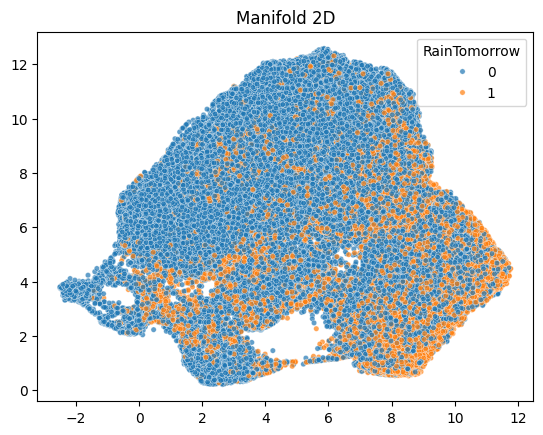

In [20]:
import umap.umap_ as umap
umap_model = umap.UMAP(n_neighbors=15, min_dist = 0.1, n_components =2)
#n_neighbors : élevé = bien pour structure globale, mais plus long
# min_dist : bas : bonne séparation des clusters, mais risque de surcompression
umap_model.fit(df_var_continue)
embedding = umap_model .transform(df_var_continue)

target = df["RainTomorrow"]

sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = target, alpha = .7, s=15)
plt.title("Manifold 2D");

Je voudrais regarder le clustering.
Le problème c'est qu'une méthode KMeans sur 10% des observations puis CAH puis KMeans final, est trop lourd.


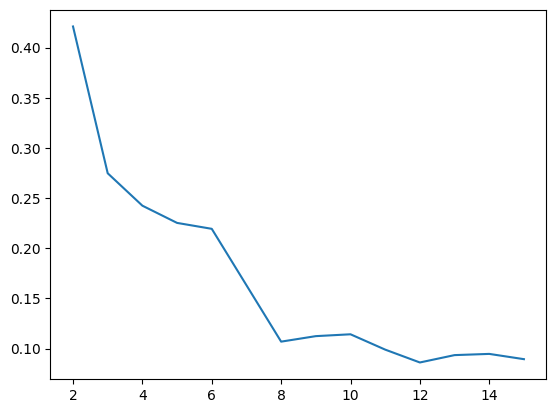

In [21]:
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score

#Mini Batch avec paramètre recommandé par le coef de silhouette
nb_clusters = 6500 #6500 pr 20%

# Créer et ajuster MiniBatchKMeans sur l'ensemble du dataset
mbk = KMeans(n_clusters=nb_clusters)
mbk.fit(df_var_continue)
# Récupérer les centroïdes des clusters
centroid_kmeans  = mbk.cluster_centers_
kmeans_predictions = mbk.predict(df_var_continue)

# STEP 3 : Appliquer un clustering hiérarchique (CAH) sur ces centroïdes
## Trouver le nb de cluster optimal pour CAH
range_n_clusters = [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15]
s_scores=[]
for k in range_n_clusters:
    cluster =  AgglomerativeClustering(n_clusters=k)
    cluster.fit(centroid_kmeans)
    coef = silhouette_score( X=centroid_kmeans, labels=cluster.labels_, metric='sqeuclidean')
    s_scores.append(coef)
list(zip(range_n_clusters,s_scores))

plt.plot(range_n_clusters,s_scores);

In [22]:
cah = AgglomerativeClustering(n_clusters=2)#cf le graph ci-dessous de coef de silhouette
cah.fit(centroid_kmeans)
liste = np.arange(0,nb_clusters)
cah_clusters = pd.DataFrame(data=cah.labels_, index=liste)

kmeans_pred = pd.DataFrame(kmeans_predictions, index=df_var_continue.index)

#Créer une nouvelle colonne dans df source : cluster_CAH
# Ajout du label des 6000 clusters du 1er Kmeans
sv_data = pd.merge(left=df_var_continue, right=kmeans_pred, left_index=True, right_index=True)
#Renommer la nouvelle colonne
sv_data=sv_data.rename(columns={0:"Label_Kmean"})
# Ajout du label des 4 clusters du CAH
sv_data=pd.merge(left=sv_data, right=cah_clusters, left_on="Label_Kmean", right_index=True)
#Renommer la nouvelle colonne
sv_data=sv_data.rename(columns={0:"cluster_CAH"})
sv_data=sv_data.drop(["Label_Kmean"],axis=1) 

#Création d'une variable : Centroïdes de chaque cluster obtenu par CAH : moyenne de chaque feature par cluster
centroids_cah = sv_data.groupby("cluster_CAH").mean() #sv_data ne sert que pour l'étape d'avant

#Application du KMeans final
kmeans2=KMeans(n_clusters=2, init=centroids_cah)
kmeans2.fit(df_var_continue)#ValueError: The shape of the initial centers (3, 25) does not match the number of features of the data 24.
kmeans2_predictions = kmeans2.predict(df_var_continue) 
kmeans2_predictions_df = pd.DataFrame(data=kmeans2_predictions, index=df_var_continue.index)

In [23]:
features_to_plot = df_var_continue.columns  
df_var_continue['Cluster'] = kmeans2.labels_
df_final = pd.merge(left=df_var_continue,right=df["RainTomorrow"], left_index=True, right_index = True)
pd.crosstab(columns=df_final['Cluster'], index=df_final["RainTomorrow"],normalize=0)

Cluster,0,1
RainTomorrow,,
0,0.882950,0.117050
1,0.574928,0.425072


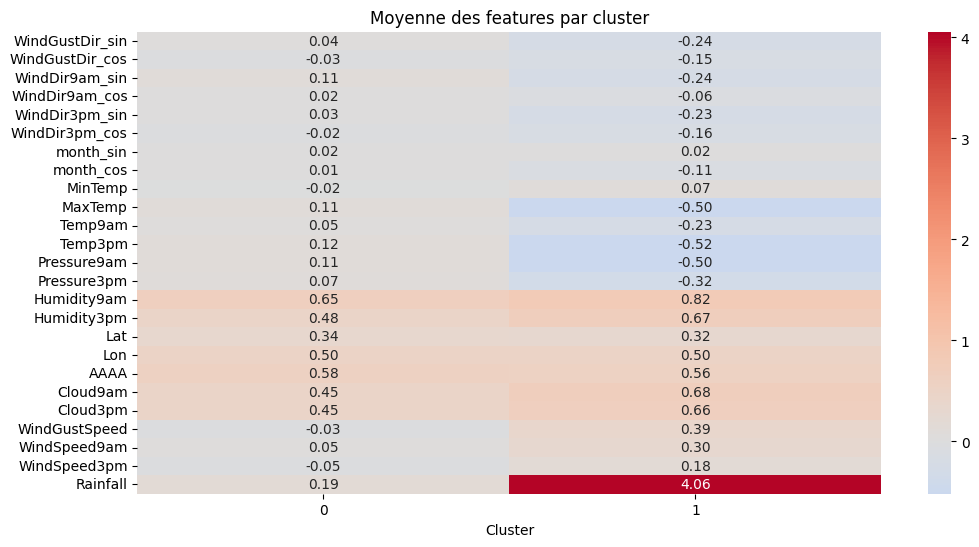

In [24]:
import seaborn as sns
df_var_continue_cluster = df_var_continue.copy()
df_var_continue_cluster = pd.merge(left=df_var_continue_cluster, right = kmeans2_predictions_df, left_index=True, right_index=True)

# Moyenne des features par cluster
cluster_means = df_var_continue.groupby('Cluster').mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, center = 0, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Moyenne des features par cluster")
plt.show()


In [25]:
silhouette_score( X=df_var_continue, labels=kmeans2.labels_, metric='euclidean') #objectif : tendre vers 1

np.float64(0.25651409415706583)

In [26]:
df.to_csv("df_sans_NaN_sans_X_train.csv", index = False)